In [2]:
import os, sys, glob
import itertools

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.io import fits
import astropy.units as u
from astropy import table
from astropy.table import join,vstack,Table
from astropy.coordinates import SkyCoord

from analyze_cluster_output import colors, shapes
from analyze_cluster_output import mass_to_bp_rp, id_solar
from analyze_cluster_output import read_cluster_visual
from plot_periods import plot_periodcolor_histogram

In [17]:
# My crossmatched catalog
per = at.read("testing_tausq/mockCluster.txt",header_start=0)
per.dtype

dtype([('period', '<f8'), ('mass', '<f8'), ('xbin', '<i8'), ('ybin', '<i8'), ('rho', '<f8'), ('(1-F)/A', '<f8'), ("rho'", '<f8'), ('tau2_i', '<f8')])

In [18]:
catmatch = per.copy()
catmatch.rename_column("period","Prot1")
catmatch.rename_column("mass","Mass")

# First we just have to set up the grid and make the model into a histogram

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35]
[ 0.         13.33333333 26.66666667 40.        ]
[[0.0577 0.0577 0.0577 0.0577 0.0577 0.0462 0.0462 0.0462 0.0577 0.0577
  0.0577 0.0577 0.0577]
 [0.     0.     0.     0.     0.     0.0115 0.0115 0.0115 0.     0.
  0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.    ]]
nomask_final max 0.0577
nomask_final sum 1.0001333333333335


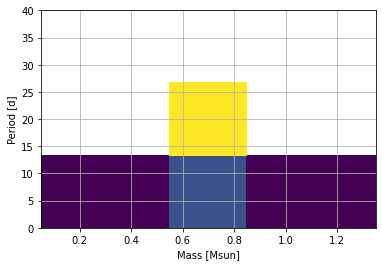

In [26]:
mass_bins = np.arange(0.05,1.45,0.1)
period_bins = np.linspace(0,40,4)

print(mass_bins)
print(period_bins)

def plot_model_histogram():
    mod_file = "testing_tausq/3x13Bins.txt"
    mod = np.loadtxt(mod_file)
    img_nomask_final = mod
#     img_nomask_final = np.asarray(mod[:])
    print(img_nomask_final)
    
    print("nomask_final max",np.max(img_nomask_final))
    
    dpdm = np.diff(mass_bins)[0]*np.diff(period_bins)[0]
    
    print("nomask_final sum",np.sum(img_nomask_final*dpdm))
    
    
    # mask the image so it doesn't show cells outside the model
    # Trying to make an array that reflects the bottom of the period bins
    # to make sure I'm not catching the period limits within a bin

    mask = img_nomask_final==0
        
    img = np.ma.masked_array(img_nomask_final,mask=mask)
#     assert np.all(img==sm.img), "masked image mismatch"


    plt.figure()
    ax = plt.subplot(111)
    
    X, Y = np.meshgrid(mass_bins,period_bins)
    ax.pcolormesh(X, Y, img, cmap="viridis_r")
#     ax.plot(mod["mass"],mod["prot"],'k.',alpha=0.25)
#     ax.set_xlim(0.025,1.325)
#     ax.set_ylim(min(self.period_bins),max(self.period_bins))
    ax.set_xlabel("Mass [Msun]")
    ax.set_ylabel("Period [d]")
    ax.grid(True)
    
    return img, mask
img, mask = plot_model_histogram()

# Calculating tau-squared

In [37]:
# area of the region containing the model
A_pm = (np.max(mass_bins)-np.min(mass_bins)) * (np.max(period_bins)-np.min(period_bins))
# print(A_pm,1/A_pm)

# model weight? value from section 5.2.3
fscript = 0.7

# background term in the tau squared sum
bkgd_i = (1-fscript)/A_pm
print(bkgd_i)

0.005769230769230769


In [28]:
use = ((catmatch["Mass"]<max(mass_bins)) & 
       (catmatch["Mass"]>=min(mass_bins)) & 
#        (catmatch["Mass"].mask==False) & 
       (catmatch["Prot1"]>0))

In [29]:
nprot = len(np.where(use)[0])
print(nprot)

4


In [30]:
bkgd_sum = bkgd_i*nprot

In [39]:
sum_rho = 0
for j in range(len(period_bins)-1):
#     print(sm.period_bins[j])
    in_p_bin = (catmatch["Prot1"]>period_bins[j]) & (catmatch["Prot1"]<=period_bins[j+1])
    for i in range(len(mass_bins)-1):
#         print(sm.mass_bins[i])
        if mask[j,i]==True:
            # No model at this index; move on
#             print(sm.mask[j,i])
            continue
        else:
            in_m_bin = (catmatch["Mass"]>mass_bins[i]) & (catmatch["Mass"]<=mass_bins[i+1])
            observed = use & in_p_bin & in_m_bin
            n_in_bin = len(np.where(observed)[0])
            if n_in_bin>0:
                print("\n",j, i, mass_bins[i],period_bins[j],n_in_bin)
                this_rho = n_in_bin * img[j,i]
                print("rho",this_rho)
                print("rho prime",this_rho*fscript + bkgd_i*n_in_bin)
                print("tau sq",-2*np.log(this_rho*fscript + bkgd_i*n_in_bin))
                sum_rho += n_in_bin * img[j,i]


 0 7 0.7500000000000002 0.0 1
rho 0.0462
rho prime 0.03810923076923076
tau sq 6.534597497572563

 0 12 1.2500000000000002 0.0 1
rho 0.0577
rho prime 0.046159230769230765
tau sq 6.151316642731774

 1 5 0.5500000000000002 13.333333333333334 1
rho 0.0115
rho prime 0.013819230769230768
tau sq 8.563388245768293


In [42]:
sum_rho

1.0752830699394793

In [43]:
tau_sq = -2 * np.log(bkgd_sum + fscript*sum_rho)

In [44]:
tau_sq

-0.4917664725259944

# Test a loop

In [45]:
def calc_tausq(model_year,model_age,period_scale):
    sm = SpinModel(model_year,model_age,period_scale)
    sm.normalize()
    sm.add_mask()
    
    # area of the region containing the model
    A_pm = (np.max(sm.mass_bins)-np.min(sm.mass_bins)) * (np.max(sm.period_bins)-np.min(sm.period_bins))
    # print(A_pm,1/A_pm)

    # model weight? value from section 5.2.3
    fscript = 0.7

    # background term in the tau squared sum
    bkgd_i = (1-fscript)/A_pm
    print("fscript:", fscript, "1 floor value:",bkgd_i)
    
    use = ((catmatch["Mass"]<max(sm.mass_bins)) & 
           (catmatch["Mass"]>=min(sm.mass_bins)) & 
           (catmatch["Mass"].mask==False) & 
           (catmatch["Prot1"]>0))
    
    nprot = len(np.where(use)[0])
    print(nprot)
    bkgd_sum = bkgd_i*nprot
    sum_rho = 0
    sum_rho_prime = 0
    for j in range(len(sm.period_bins)-1):
    #     print(sm.period_bins[j])
        in_p_bin = (catmatch["Prot1"]>sm.period_bins[j]) & (catmatch["Prot1"]<=sm.period_bins[j+1])
        for i in range(len(sm.mass_bins)-1):
    #         print(sm.mass_bins[i])
            # TODO: this might be the wrong way to add this?
#             sum_rho += bkgd_i
            if sm.mask[j,i]==True:
                # No model at this index; move on
    #             print(sm.mask[j,i])
                continue
            else:
                in_m_bin = (catmatch["Mass"]>sm.mass_bins[i]) & (catmatch["Mass"]<=sm.mass_bins[i+1])
                observed = use & in_p_bin & in_m_bin
                n_in_bin = len(np.where(observed)[0])
                if n_in_bin>0:
    #                 print(sm.mass_bins[i],sm.period_bins[j],n_in_bin)
                    this_rho = fscript * n_in_bin * sm.img[j,i]
                    print("N",n_in_bin,"rho:",this_rho,"rho prime:",this_rho+bkgd_i*n_in_bin)
                    sum_rho += this_rho
                    sum_rho_prime += this_rho + bkgd_i*n_in_bin
    print("sum rho:",sum_rho)
    sum_rho += bkgd_sum
    print("sum rho prime:",sum_rho)
    print("sum rho prime alt:",sum_rho_prime)
    tau_sq = -2 * np.log(sum_rho)
    print("tau2:",tau_sq)
    
#     print(model_year,model_age,period_scale,tau_sq)
    
    return tau_sq

In [46]:
# Find all the model ages I have
model_year = 2022
period_scale = "linear"
models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/UpSco_Mattea{model_year}/UpSco_Mattea{model_year}*Myr.txt"))
# print(models)

model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
# print(model_ages)

all_tau_sq = np.zeros(len(model_ages))
for i, age in enumerate(model_ages):
    print("\n",age)
    all_tau_sq[i] = calc_tausq(model_year,age,period_scale)


 8
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.0035897435897435893 rho prime: 0.01512820512820513
N 2 rho: 0.00769230769230769 rho prime: 0.019230769230769232
N 1 rho: 0.0026923076923076952 rho prime: 0.008461538461538465
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.005982905982905982 rho prime: 0.01752136752136752
N 3 rho: 0.006730769230769236 rho prime: 0.02403846153846155
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.008158508158508158 rho prime: 0.01392773892773893
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.002393162393162394 rho prime: 0.008162393162393165
N 1 rho: 0.0011217948717948734 rho prime: 0.006891025641025644
N 1 rho: 0.005128205128205129 rho prime: 0.0108974358974359
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0051282051282051265 rho prime: 0.010897435897435897
N 1 rho: 

N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.005608974358974362 rho prime: 0.011378205128205133
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.0041420118343195155 rho prime: 0.009911242603550287
N 1 rho: 0.00493247210804463 rho prime: 0.0107017028772754
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.004377736085053155 rho prime: 0.010146966854283925
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 4 rho: 0.0 rho prime: 0.02307692307692308
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 1 rho: 0.0012820512820512816 rho prime: 0.007051282051282052
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0020710059171597578 rho prime: 0.007840236686390528
N 1 rho

sum rho: 0.18607729472127452
sum rho prime: 0.7110772947212747
sum rho prime alt: 0.6937696024135819
tau2: 0.6819482847990843

 13
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.0070043777360850506 rho prime: 0.018542839274546592
N 2 rho: 0.008376068376068375 rho prime: 0.019914529914529917
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 2 rho: 0.005128205128205127 rho prime: 0.01666666666666667
N 1 rho: 0.008076923076923086 rho prime: 0.013846153846153855
N 1 rho: 0.003167420814479641 rho prime: 0.008936651583710412
N 2 rho: 0.0023931623931623927 rho prime: 0.013931623931623933
N 3 rho: 0.003365384615384619 rho prime: 0.020673076923076933
N 2 rho: 0.015384615384615382 rho prime: 0.026923076923076925
N 1 rho: 0.002188868042526578 rho prime: 0.007958098811757349
N 1 rho: 0.0011217948717948728 rho prime: 0.006891025641025643
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002991452991452991 rho prime: 0.00

N 1 rho: 0.005608974358974364 rho prime: 0.011378205128205135
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.002564102564102563 rho prime: 0.014102564102564105
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.004110393423370523 rho prime: 0.009879624192601293
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.002564102564102563 rho prime: 0.014102564102564105
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.0030644152595372095 rho prime: 0.00883364602876798
N 1 rho: 0.002692307692307694 rho prime: 0.008461538461538465
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 4 rho: 0.021538461538461572 rho prime: 0.044615384615384654
N 2 rho: 0.012669683257918571 rho prime: 0.024208144796380112
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho

sum rho: 0.19774000432274272
sum rho prime: 0.7227400043227429
sum rho prime alt: 0.7112015427842809
tau2: 0.6494114564864879

 18
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.007879924953095686 rho prime: 0.019418386491557228
N 2 rho: 0.007179487179487178 rho prime: 0.01871794871794872
N 2 rho: 0.007692307692307691 rho prime: 0.019230769230769232
N 2 rho: 0.010256410256410255 rho prime: 0.021794871794871794
N 1 rho: 0.002071005917159761 rho prime: 0.007840236686390532
N 1 rho: 0.0053846153846153905 rho prime: 0.01115384615384616
N 1 rho: 0.009502262443438924 rho prime: 0.015271493212669695
N 2 rho: 0.005982905982905982 rho prime: 0.01752136752136752
N 3 rho: 0.003365384615384618 rho prime: 0.02067307692307693
N 2 rho: 0.01282051282051282 rho prime: 0.024358974358974363
N 1 rho: 0.004377736085053157 rho prime: 0.010146966854283929
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0016317016317016313 rho prime: 0.007400932400932402
N 1 rho: 0.006334841628959281 rho

N 1 rho: 0.0033653846153846186 rho prime: 0.009134615384615389
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.00306441525953721 rho prime: 0.00883364602876798
N 1 rho: 0.002692307692307694 rho prime: 0.008461538461538465
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 4 rho: 0.010769230769230788 rho prime: 0.03384615384615387
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0011217948717948728 rho prime: 0.006891025641025643
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.002393162393162392 rho prime: 0.008162393162393162
N 1 rho: 0.002692307692307694 rho prime: 0.008461538461538465
N 1 rho: 0.0033653846153846186 rho prime: 0.00913461538

sum rho: 0.22264776159971336
sum rho prime: 0.7476477615997135
sum rho prime alt: 0.7361093000612515
tau2: 0.5816466377428281

 23
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.009631019387116945 rho prime: 0.021169480925578486
N 2 rho: 0.008376068376068373 rho prime: 0.019914529914529914
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438922 rho prime: 0.015271493212669691
N 2 rho: 0.014358974358974357 rho prime: 0.0258974358974359
N 3 rho: 0.0033653846153846177 rho prime: 0.02067307692307693
N 2 rho: 0.010256410256410256 rho prime: 0.021794871794871797
N 1 rho: 0.004815509693558472 rho prime: 0.010584740462789243
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0031674208144796398 rho prime: 0.00893

sum rho: 0.22079520129168456
sum rho prime: 0.7457952012916846
sum rho prime alt: 0.734256739753223
tau2: 0.5866084911360121

 25
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.009631019387116945 rho prime: 0.021169480925578486
N 2 rho: 0.007179487179487179 rho prime: 0.01871794871794872
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438925 rho prime: 0.015271493212669695
N 2 rho: 0.01435897435897436 rho prime: 0.0258974358974359
N 3 rho: 0.0033653846153846186 rho prime: 0.02067307692307693
N 2 rho: 0.005128205128205128 rho prime: 0.01666666666666667
N 1 rho: 0.005253283302063788 rho prime: 0.011022514071294558
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0 rho prime: 0.00576923076

sum rho: 0.22369737691408728
sum rho prime: 0.7486973769140874
sum rho prime alt: 0.7313896846063948
tau2: 0.5788408265445748

 27
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.007004377736085049 rho prime: 0.01854283927454659
N 2 rho: 0.008376068376068373 rho prime: 0.019914529914529914
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.01025641025641025 rho prime: 0.02179487179487179
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438925 rho prime: 0.015271493212669695
N 2 rho: 0.01316239316239316 rho prime: 0.024700854700854702
N 3 rho: 0.0033653846153846186 rho prime: 0.02067307692307693
N 2 rho: 0.002564102564102564 rho prime: 0.014102564102564105
N 1 rho: 0.0056910569105691035 rho prime: 0.011460287679799874
N 1 rho: 0.0033653846153846186 rho prime: 0.009134615384615389
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 

N 1 rho: 0.0029914529914529917 rho prime: 0.008760683760683763
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.005128205128205126 rho prime: 0.010897435897435897
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 1 rho: 0.0033653846153846186 rho prime: 0.009134615384615389
N 2 rho: 0.007692307692307687 rho prime: 0.01923076923076923
N 1 rho: 0.00207100591715976 rho prime: 0.00784023668639053
N 1 rho: 0.004932472108044628 rho prime: 0.010701702877275399
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.0017510944340212622 rho prime: 0.007520325203252033
N 1 rho: 0.002692307692307695 rho prime: 0.008461538461538465
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.010769230769230791 rho 

N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 1 rho: 0.0051282051282051265 rho prime: 0.010897435897435897
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.00207100591715976 rho prime: 0.00784023668639053
N 1 rho: 0.0032883147386964192 rho prime: 0.00905754550792719
N 1 rho: 0.0033653846153846173 rho prime: 0.009134615384615387
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.0013133208255159468 rho prime: 0.0070825515947467175
N 1 rho: 0.002692307692307695 rho prime: 0.008461538461538465
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.010769230769230791 rho prime: 0.03384615384615387
N 2 rho: 0.0 

N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.002466236054022314 rho prime: 0.008235466823253084
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.00538461538461539 rho prime: 0.01115384615384616
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.010769230769230791 rho prime: 0.03384615384615387
N 2 rho: 0.006334841628959286 rho prime: 0.017873303167420827
N 1 rho: 0.005608974358974362 rho prime: 0.011378205128205133
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.0065268065268065225 rho prime: 

sum rho: 0.22923638725163856
sum rho prime: 0.7542363872516387
sum rho prime alt: 0.7426979257131768
tau2: 0.5640988983292998

 36
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.005253283302063788 rho prime: 0.016791744840525327
N 2 rho: 0.007179487179487179 rho prime: 0.01871794871794872
N 2 rho: 0.017948717948717944 rho prime: 0.029487179487179487
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438922 rho prime: 0.015271493212669691
N 2 rho: 0.011965811965811963 rho prime: 0.023504273504273504
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 2 rho: 0.002564102564102564 rho prime: 0.014102564102564105
N 1 rho: 0.004815509693558472 rho prime: 0.010584740462789243
N 1 rho: 0.005608974358974362 rho prime: 0.011378205128205133
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 

sum rho: 0.21459794173047889
sum rho prime: 0.739597941730479
sum rho prime alt: 0.7280594801920173
tau2: 0.6032971248452709

 38
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.004377736085053158 rho prime: 0.015916197623514698
N 2 rho: 0.007179487179487179 rho prime: 0.01871794871794872
N 2 rho: 0.01794871794871794 rho prime: 0.02948717948717948
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.004142011834319522 rho prime: 0.009911242603550292
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438924 rho prime: 0.015271493212669695
N 2 rho: 0.011965811965811963 rho prime: 0.023504273504273504
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 2 rho: 0.0025641025641025637 rho prime: 0.014102564102564105
N 1 rho: 0.005691056910569104 rho prime: 0.011460287679799876
N 1 rho: 0.005608974358974363 rho prime: 0.011378205128205133
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 r

N 1 rho: 0.0033653846153846177 rho prime: 0.009134615384615389
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0036993540810334722 rho prime: 0.009468584850264243
N 1 rho: 0.0033653846153846177 rho prime: 0.009134615384615389
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.00950226244343892 rho prime: 0.015271493212669691
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.0026923076923076952 rho prime: 0.008461538461538465
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.021538461538461586 rho prime: 0.04461538461538467
N 2 rho: 0.012669683257918575 rho prime: 0.024208144796380116
N 1 rho: 0.002243589743589745 rho prime: 0.008012820512820516
N 1 rho: 0.0025641025641025632 r

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025637 rho prime: 0.008333333333333335
N 2 rho: 0.0070043777360850506 rho prime: 0.018542839274546592
N 2 rho: 0.008376068376068375 rho prime: 0.019914529914529917
N 2 rho: 0.01794871794871794 rho prime: 0.02948717948717948
N 2 rho: 0.02051282051282051 rho prime: 0.03205128205128205
N 1 rho: 0.004142011834319522 rho prime: 0.009911242603550292
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438924 rho prime: 0.015271493212669695
N 2 rho: 0.009572649572649571 rho prime: 0.021111111111111112
N 3 rho: 0.003365384615384618 rho prime: 0.02067307692307693
N 2 rho: 0.0025641025641025637 rho prime: 0.014102564102564105
N 1 rho: 0.0070043777360850506 rho prime: 0.012773608505315821
N 1 rho: 0.00448717948717949 rho prime: 0.010256410256410262
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.00950226244343892 rho prime: 0.015271493212669691
N 1 rho: 0.004786324786324787 rho prime: 0.010555555555555

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.007879924953095682 rho prime: 0.01941838649155722
N 2 rho: 0.009572649572649573 rho prime: 0.021111111111111115
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.020512820512820506 rho prime: 0.03205128205128205
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438922 rho prime: 0.015271493212669691
N 2 rho: 0.008376068376068376 rho prime: 0.019914529914529917
N 3 rho: 0.0033653846153846177 rho prime: 0.02067307692307693
N 2 rho: 0.007692307692307693 rho prime: 0.019230769230769232
N 1 rho: 0.007004377736085049 rho prime: 0.01277360850531582
N 1 rho: 0.0044871794871794895 rho prime: 0.01025641025641026
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.004786324786324787 rho prime: 0.01055555555555555

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0051282051282051265 rho prime: 0.010897435897435897
N 2 rho: 0.009631019387116945 rho prime: 0.021169480925578486
N 2 rho: 0.01316239316239316 rho prime: 0.024700854700854702
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.020512820512820506 rho prime: 0.03205128205128205
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438922 rho prime: 0.015271493212669691
N 2 rho: 0.004786324786324786 rho prime: 0.016324786324786327
N 3 rho: 0.010096153846153854 rho prime: 0.027403846153846168
N 2 rho: 0.007692307692307693 rho prime: 0.019230769230769232
N 1 rho: 0.007004377736085049 rho prime: 0.01277360850531582
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.0035897435897435906 rho prime: 0.009358974358974

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0051282051282051265 rho prime: 0.010897435897435897
N 2 rho: 0.009631019387116945 rho prime: 0.021169480925578486
N 2 rho: 0.01555555555555555 rho prime: 0.02709401709401709
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.020512820512820506 rho prime: 0.03205128205128205
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.00950226244343892 rho prime: 0.015271493212669691
N 2 rho: 0.002393162393162393 rho prime: 0.013931623931623935
N 3 rho: 0.013461538461538471 rho prime: 0.030769230769230785
N 2 rho: 0.007692307692307693 rho prime: 0.019230769230769232
N 1 rho: 0.007442151344590365 rho prime: 0.013211382113821135
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.0029914529914529917 rho prime: 0.008760683760683

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.005128205128205127 rho prime: 0.010897435897435897
N 2 rho: 0.010506566604127576 rho prime: 0.022045028142589115
N 2 rho: 0.015555555555555553 rho prime: 0.027094017094017094
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.02051282051282051 rho prime: 0.03205128205128205
N 1 rho: 0.004142011834319522 rho prime: 0.009911242603550292
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.00950226244343892 rho prime: 0.015271493212669691
N 2 rho: 0.0023931623931623936 rho prime: 0.013931623931623935
N 3 rho: 0.013461538461538473 rho prime: 0.030769230769230785
N 2 rho: 0.010256410256410255 rho prime: 0.021794871794871794
N 1 rho: 0.006566604127579735 rho prime: 0.012335834896810505
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.002991452991452992 rho prime: 0.00876068376068

N 1 rho: 0.0011217948717948728 rho prime: 0.006891025641025643
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 1 rho: 0.0033653846153846186 rho prime: 0.009134615384615389
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.0012331180270111573 rho prime: 0.007002348796241928
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.0017510944340212626 rho prime: 0.007520325203252033
N 1 rho: 0.0053846153846153905 rho prime: 0.01115384615384616
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.010769230769230793 rho prime: 0.03384615384615387
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0022435897435897456 rho prime: 0.008012820512820516
N 1 rho: 0.0025641025641025632 rho prime: 0.008333

N 1 rho: 0.002071005917159761 rho prime: 0.007840236686390532
N 1 rho: 0.0004110393423370524 rho prime: 0.0061802701115678225
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.0053846153846153905 rho prime: 0.01115384615384616
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.010769230769230793 rho prime: 0.03384615384615387
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.002243589743589745 rho prime: 0.008012820512820516
N 1 rho: 0.003846153846153845 rho prime: 0.009615384615384616
N 2 rho: 0.0032634032634032612 rho prime: 0.014801864801864802
N 1 rho: 0.002071005917159761 rho prime: 0.007840236686390532
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.004786324786324785 rho prime: 0.01055555555

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0051282051282051265 rho prime: 0.010897435897435897
N 2 rho: 0.011382113821138209 rho prime: 0.02292057535959975
N 2 rho: 0.01555555555555555 rho prime: 0.02709401709401709
N 2 rho: 0.012820512820512818 rho prime: 0.02435897435897436
N 2 rho: 0.020512820512820506 rho prime: 0.03205128205128205
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.012669683257918559 rho prime: 0.01843891402714933
N 2 rho: 0.00358974358974359 rho prime: 0.015128205128205131
N 3 rho: 0.01682692307692309 rho prime: 0.0341346153846154
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.00919324577861163 rho prime: 0.014962476547842399
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0029914529914529917 rho prime: 0.008760683760683763
N 1 rho: 0.0033653846153846195 rho pr

sum rho: 0.2678799225949099
sum rho prime: 0.79287992259491
sum rho prime alt: 0.781341461056448
tau2: 0.46416698101783155

 68
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.005128205128205127 rho prime: 0.010897435897435897
N 2 rho: 0.01225766103814884 rho prime: 0.02379612257661038
N 2 rho: 0.016752136752136753 rho prime: 0.028290598290598296
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.02051282051282051 rho prime: 0.03205128205128205
N 1 rho: 0.002071005917159761 rho prime: 0.007840236686390532
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438924 rho prime: 0.015271493212669695
N 2 rho: 0.0035897435897435906 rho prime: 0.015128205128205131
N 3 rho: 0.016826923076923093 rho prime: 0.0341346153846154
N 2 rho: 0.010256410256410255 rho prime: 0.021794871794871794
N 1 rho: 0.007442151344590367 rho prime: 0.013211382113821137
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 r

sum rho: 0.2831798056846339
sum rho prime: 0.8081798056846341
sum rho prime alt: 0.7966413441461722
tau2: 0.42594142685930764

 72
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.005128205128205127 rho prime: 0.010897435897435897
N 2 rho: 0.01313320825515947 rho prime: 0.02467166979362101
N 2 rho: 0.016752136752136753 rho prime: 0.028290598290598296
N 2 rho: 0.01538461538461538 rho prime: 0.02692307692307692
N 2 rho: 0.02051282051282051 rho prime: 0.03205128205128205
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 2 rho: 0.0035897435897435906 rho prime: 0.015128205128205131
N 3 rho: 0.016826923076923087 rho prime: 0.0341346153846154
N 2 rho: 0.010256410256410255 rho prime: 0.021794871794871794
N 1 rho: 0.0070043777360850506 rho prime: 0.012773608505315821
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0

N 1 rho: 0.0025641025641025645 rho prime: 0.008333333333333335
N 1 rho: 0.0033653846153846173 rho prime: 0.009134615384615387
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.012237762237762219 rho prime: 0.01800699300699299
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.00207100591715976 rho prime: 0.00784023668639053
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.002564102564102563 rho prime: 0.014102564102564105
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0030644152595372095 rho prime: 0.00883364602876798
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.021538461538461583 rho prime: 0.04461538461538467
N 2 rho: 0.012669683257918571 rho prime: 0.024208144796380112
N 1 rho: 0.0011217948717948724 rho prime: 0.00689102

N 1 rho: 0.0033653846153846173 rho prime: 0.009134615384615387
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.012237762237762219 rho prime: 0.01800699300699299
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.00207100591715976 rho prime: 0.00784023668639053
N 1 rho: 0.0008220786846741048 rho prime: 0.0065913094539048755
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0030644152595372095 rho prime: 0.00883364602876798
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 4 rho: 0.010769230769230791 rho prime: 0.03384615384615387
N 2 rho: 0.012669683257918571 rho prime: 0.024208144796380112
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 1 rho: 0.0012820512820512814 rho prime: 0.007051

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0051282051282051265 rho prime: 0.010897435897435897
N 2 rho: 0.015759849906191368 rho prime: 0.02729831144465291
N 2 rho: 0.01675213675213675 rho prime: 0.02829059829059829
N 2 rho: 0.012820512820512818 rho prime: 0.02435897435897436
N 2 rho: 0.020512820512820506 rho prime: 0.03205128205128205
N 1 rho: 0.004142011834319521 rho prime: 0.00991124260355029
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 2 rho: 0.002393162393162393 rho prime: 0.013931623931623935
N 3 rho: 0.01682692307692309 rho prime: 0.0341346153846154
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.005691056910569104 rho prime: 0.011460287679799876
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0035897435897435906 rho prime: 0.009358974358974361
N 1 rho: 0.00336

N 1 rho: 0.005691056910569104 rho prime: 0.011460287679799876
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0029914529914529917 rho prime: 0.008760683760683763
N 1 rho: 0.0033653846153846195 rho prime: 0.00913461538461539
N 1 rho: 0.005128205128205128 rho prime: 0.010897435897435899
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.009790209790209775 rho prime: 0.015559440559440547
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0016441573693482096 rho prime: 0.00741338813857898
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0031674208144796398 rho prime: 0.008

N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 4 rho: 0.0 rho prime: 0.02307692307692308
N 2 rho: 0.012669683257918575 rho prime: 0.024208144796380116
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.003589743589743589 rho prime: 0.00935897435897436
N 1 rho: 0.005384615384615388 rho prime: 0.011153846153846158
N 1 rho: 0.0033653846153846177 rho prime: 0.009134615384615389
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 1 rho: 0.00

N 1 rho: 0.0016441573693482096 rho prime: 0.00741338813857898
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 4 rho: 0.0 rho prime: 0.02307692307692308
N 2 rho: 0.012669683257918571 rho prime: 0.024208144796380112
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 1 rho: 0.0012820512820512816 rho prime: 0.007051282051282052
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.0035897435897435884 rho prime: 0.00935897435897436
N 1 rho: 0.005384615384615388 rho prime: 0.01115

N 1 rho: 0.0016441573693482096 rho prime: 0.00741338813857898
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.006334841628959281 rho prime: 0.01210407239819005
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.004895104895104888 rho prime: 0.010664335664335658
N 4 rho: 0.0 rho prime: 0.02307692307692308
N 2 rho: 0.012669683257918575 rho prime: 0.024208144796380116
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.0041880341880341865 rho prime: 0.009957264957264957
N 1 rho: 0.0026923076923076952 rho prime: 0.008461538461538465
N 1 

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.017510944340212633 rho prime: 0.029049405878674175
N 2 rho: 0.01555555555555555 rho prime: 0.02709401709401709
N 2 rho: 0.012820512820512818 rho prime: 0.02435897435897436
N 2 rho: 0.020512820512820506 rho prime: 0.03205128205128205
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.005384615384615389 rho prime: 0.01115384615384616
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 2 rho: 0.004786324786324786 rho prime: 0.016324786324786327
N 3 rho: 0.01682692307692309 rho prime: 0.0341346153846154
N 2 rho: 0.005128205128205128 rho prime: 0.01666666666666667
N 1 rho: 0.0056910569105691035 rho prime: 0.011460287679799874
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0029914529914529917 rho prime: 0.008760683760683763
N 1 rho: 0.00224

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025637 rho prime: 0.008333333333333335
N 2 rho: 0.017510944340212633 rho prime: 0.029049405878674175
N 2 rho: 0.01555555555555555 rho prime: 0.02709401709401709
N 2 rho: 0.01282051282051282 rho prime: 0.024358974358974363
N 2 rho: 0.02051282051282051 rho prime: 0.03205128205128205
N 1 rho: 0.002071005917159761 rho prime: 0.007840236686390532
N 1 rho: 0.00538461538461539 rho prime: 0.01115384615384616
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 2 rho: 0.0047863247863247855 rho prime: 0.016324786324786327
N 3 rho: 0.016826923076923093 rho prime: 0.0341346153846154
N 2 rho: 0.007692307692307694 rho prime: 0.019230769230769235
N 1 rho: 0.005691056910569104 rho prime: 0.011460287679799876
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002991452991452991 rho prime: 0.00876068376068376
N 1 rho: 0.00224358

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.017510944340212633 rho prime: 0.029049405878674175
N 2 rho: 0.015555555555555548 rho prime: 0.02709401709401709
N 2 rho: 0.012820512820512818 rho prime: 0.02435897435897436
N 2 rho: 0.015384615384615377 rho prime: 0.026923076923076918
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.005384615384615389 rho prime: 0.01115384615384616
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 2 rho: 0.004786324786324785 rho prime: 0.016324786324786324
N 3 rho: 0.01682692307692309 rho prime: 0.0341346153846154
N 2 rho: 0.005128205128205128 rho prime: 0.01666666666666667
N 1 rho: 0.0056910569105691035 rho prime: 0.011460287679799874
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.00358974358974359 rho prime: 0.00935897435897436

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025637 rho prime: 0.008333333333333335
N 2 rho: 0.017510944340212633 rho prime: 0.029049405878674175
N 2 rho: 0.01555555555555555 rho prime: 0.02709401709401709
N 2 rho: 0.01282051282051282 rho prime: 0.024358974358974363
N 2 rho: 0.010256410256410255 rho prime: 0.021794871794871794
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.00538461538461539 rho prime: 0.01115384615384616
N 1 rho: 0.003167420814479641 rho prime: 0.008936651583710412
N 2 rho: 0.0035897435897435893 rho prime: 0.01512820512820513
N 3 rho: 0.013461538461538473 rho prime: 0.030769230769230785
N 2 rho: 0.005128205128205128 rho prime: 0.01666666666666667
N 1 rho: 0.005691056910569104 rho prime: 0.011460287679799876
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0016317016317016313 rho prime: 0.007400932400932402
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 1 rho: 0.002991452

fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025624 rho prime: 0.008333333333333333
N 2 rho: 0.017510944340212633 rho prime: 0.029049405878674175
N 2 rho: 0.015555555555555548 rho prime: 0.02709401709401709
N 2 rho: 0.012820512820512818 rho prime: 0.02435897435897436
N 2 rho: 0.01025641025641025 rho prime: 0.02179487179487179
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.008076923076923082 rho prime: 0.013846153846153852
N 1 rho: 0.0031674208144796406 rho prime: 0.00893665158371041
N 2 rho: 0.0023931623931623923 rho prime: 0.013931623931623933
N 3 rho: 0.010096153846153857 rho prime: 0.027403846153846168
N 2 rho: 0.002564102564102564 rho prime: 0.014102564102564105
N 1 rho: 0.0056910569105691035 rho prime: 0.011460287679799874
N 1 rho: 0.002243589743589745 rho prime: 0.008012820512820516
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.00239316

N 2 rho: 0.012820512820512818 rho prime: 0.02435897435897436
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.008076923076923084 rho prime: 0.013846153846153855
N 2 rho: 0.002393162393162393 rho prime: 0.013931623931623935
N 3 rho: 0.006730769230769237 rho prime: 0.02403846153846155
N 2 rho: 0.002564102564102564 rho prime: 0.014102564102564105
N 1 rho: 0.0056910569105691035 rho prime: 0.011460287679799874
N 1 rho: 0.0033653846153846186 rho prime: 0.009134615384615389
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0011965811965811968 rho prime: 0.006965811965811967
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.012

sum rho: 0.1409801742464226
sum rho prime: 0.6659801742464228
sum rho prime alt: 0.6544417127079609
tau2: 0.8129907545672003

 188
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.016635397123201997 rho prime: 0.02817385866166354
N 2 rho: 0.014358974358974357 rho prime: 0.0258974358974359
N 2 rho: 0.015384615384615377 rho prime: 0.026923076923076918
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.005384615384615389 rho prime: 0.01115384615384616
N 2 rho: 0.004786324786324786 rho prime: 0.016324786324786327
N 3 rho: 0.0033653846153846186 rho prime: 0.02067307692307693
N 2 rho: 0.0025641025641025632 rho prime: 0.014102564102564105
N 1 rho: 0.005253283302063788 rho prime: 0.011022514071294558
N 1 rho: 0.0033653846153846186 rho prime: 0.009134615384615389
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.003167420814479639

N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 2 rho: 0.002564102564102563 rho prime: 0.014102564102564105
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 4 rho: 0.0 rho prime: 0.02307692307692308
N 2 rho: 0.006334841628959287 rho prime: 0.017873303167420827
N 1 rho: 0.0011217948717948724 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0017510944340212622 rho prime: 0.007520325203252033
N 1 rho: 0.0017948717948717936 rho prime: 0.007564102564102564
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0012820512

sum rho: 0.13891692991891516
sum rho prime: 0.6639169299189153
sum rho prime alt: 0.6293015453035301
tau2: 0.8191964857517137

 233
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.01313320825515947 rho prime: 0.02467166979362101
N 2 rho: 0.01555555555555555 rho prime: 0.02709401709401709
N 2 rho: 0.01282051282051282 rho prime: 0.024358974358974363
N 2 rho: 0.010256410256410253 rho prime: 0.021794871794871794
N 1 rho: 0.002692307692307695 rho prime: 0.008461538461538465
N 2 rho: 0.0023931623931623927 rho prime: 0.013931623931623933
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 2 rho: 0.0025641025641025637 rho prime: 0.014102564102564105
N 1 rho: 0.004815509693558473 rho prime: 0.010584740462789243
N 1 rho: 0.0022435897435897447 rho prime: 0.008012820512820516
N 1 rho: 0.0016317016317016306 rho prime: 0.007400932400932401
N 1 rho: 0.0035897435897435906 rho prime: 0.009358974358974361
N 1 rho: 0.0022435897435897456 rho prime: 0.008012820512820516
N 1 rho: 0.0025641025641025

N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0012331180270111568 rho prime: 0.007002348796241927
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 1 rho: 0.0063348416289592795 rho prime: 0.01210407239819005
N 1 rho: 0.002626641651031894 rho prime: 0.008395872420262664
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.004895104895104888 rho prime: 0.010664335664335658
N 4 rho: 0.0 rho prime: 0.02307692307692308
N 2 rho: 0.006334841628959287 rho prime: 0.017873303167420827
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.009502262443438922 rho prime: 0.015271493212669691
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0017510944340212622 rho prime

sum rho: 0.13187662305082107
sum rho prime: 0.6568766230508212
sum rho prime alt: 0.6164920076662052
tau2: 0.8405181329737638

 290
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.007879924953095682 rho prime: 0.01941838649155722
N 2 rho: 0.009572649572649573 rho prime: 0.021111111111111115
N 2 rho: 0.00769230769230769 rho prime: 0.019230769230769232
N 2 rho: 0.0051282051282051265 rho prime: 0.016666666666666666
N 2 rho: 0.008376068376068376 rho prime: 0.019914529914529917
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 2 rho: 0.010256410256410256 rho prime: 0.021794871794871797
N 1 rho: 0.006128830519074419 rho prime: 0.01189806128830519
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0011965811965811968 rho prime: 0.006965811965811967
N 1 rho: 0.0011217948717948734 rho prime: 0.006891025641025644
N 1 rho: 0.002564102564102564 rho prime: 0.008333333333333335
N 1 rho: 0.0011217948717948726 rho prime: 0.00

sum rho: 0.0949304340627569
sum rho prime: 0.619930434062757
sum rho prime alt: 0.5737765879089104
tau2: 0.9562960207256535

 331
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.007879924953095684 rho prime: 0.019418386491557225
N 2 rho: 0.004786324786324785 rho prime: 0.016324786324786324
N 2 rho: 0.005128205128205127 rho prime: 0.01666666666666667
N 2 rho: 0.005128205128205127 rho prime: 0.01666666666666667
N 2 rho: 0.010769230769230769 rho prime: 0.02230769230769231
N 3 rho: 0.003365384615384619 rho prime: 0.020673076923076933
N 2 rho: 0.007692307692307694 rho prime: 0.019230769230769235
N 1 rho: 0.0043777360850531565 rho prime: 0.010146966854283927
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0011965811965811968 rho prime: 0.006965811965811967
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0011217948717948728 rho prime: 0.006891025641025643
N 1 rho: 0.002564102564

N 1 rho: 0.01223776223776222 rho prime: 0.018006993006992992
N 2 rho: 0.006334841628959286 rho prime: 0.017873303167420827
N 1 rho: 0.0011217948717948728 rho prime: 0.006891025641025643
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0031674208144796393 rho prime: 0.00893665158371041
N 1 rho: 0.004895104895104888 rho prime: 0.010664335664335658
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.0005982905982905982 rho prime: 0.0063675213675213685
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0012820512820512816 rho prime: 0.007051282051282052
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0017948717948717944 rho prime: 0.007564102564102565
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 1 rho: 0.0016317016317016313 rho prime

N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0031674208144796398 rho prime: 0.00893665158371041
N 1 rho: 0.002447552447552444 rho prime: 0.008216783216783215
N 1 rho: 0.0008755472170106311 rho prime: 0.006644777986241401
N 1 rho: 0.000598290598290598 rho prime: 0.0063675213675213685
N 1 rho: 0.0011217948717948726 rho prime: 0.0068910256410256426
N 1 rho: 0.0012820512820512816 rho prime: 0.007051282051282052
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 1 rho: 0.0 

N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0005982905982905981 rho prime: 0.0063675213675213685
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 3 rho: 0.0 rho prime: 0.017307692307692312
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0025641025641025632 rho prime: 0.008333333333333333
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001631701631701631 rho prime: 0.007400932400932402
N 1 rho: 0.0020710059171597604 rho prime: 0.007840236686390532
N 1 rho: 0.0 rho prime: 0.00576923076923077

sum rho: 0.043393617259051984
sum rho prime: 0.5683936172590521
sum rho prime alt: 0.37223977110520573
tau2: 1.1298822242685063

 574
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.002626641651031895 rho prime: 0.014165103189493437
N 2 rho: 0.0035897435897435893 rho prime: 0.01512820512820513
N 2 rho: 0.005128205128205123 rho prime: 0.016666666666666663
N 2 rho: 0.002393162393162393 rho prime: 0.013931623931623935
N 3 rho: 0.0033653846153846164 rho prime: 0.02067307692307693
N 2 rho: 0.002564102564102562 rho prime: 0.014102564102564103
N 1 rho: 0.001751094434021263 rho prime: 0.007520325203252034
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0011965811965811968 rho prime: 0.006965811965811967
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.001121794871794872 rho prime: 0.0068910256410256426
N 2 rho: 0.0 rho prime: 0.01153846153846154
N 1 rho: 0.002466236054022315 rho prime: 0.008235466823253086
N 1 rho: 0.0 rho 

N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
sum rho: 0.04736176735199261
sum rho prime: 0.5723617673519927
sum rho prime alt: 0.3069771519673772
tau2: 1.1159680542311008

 681
fscript: 0.7 1 floor value: 0.00576923076923077
91
N 2 rho: 0.002626641651031894 rho prime: 0.014165103189493435
N 2 rho: 0.004786324786324785 rho prime: 0.016324786324786324
N 2 rho: 0.0025641025641025637 rho prime: 0.014102564102564105
N 2 rho: 0.0011965811965811961 rho prime: 0.012735042735042737
N 3 rho: 0.006730769230769238 rho prime: 0.02403846153846155
N 2 rho: 0.002564102564102564 rho prime: 0.014102564102564105
N 1 rho: 0.001313320825515947 rho prime: 0.0070825515947467175
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.00576923076923077
N 1 rho: 0.0 rho prime: 0.005

Text(0, 0.5, 'tau squared')

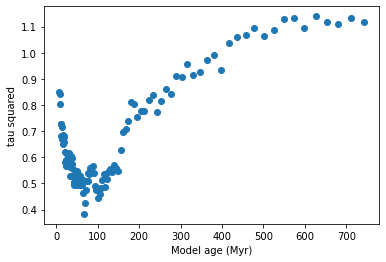

In [47]:
plt.plot(model_ages,all_tau_sq,'o')
plt.xlabel("Model age (Myr)")
plt.ylabel("tau squared")

# Try with praesepe

In [48]:
prae = at.read("catalogs/rampalli_apjac0c1et4_mrt.txt")

In [49]:
def calc_tausq_praesepe(model_year,model_age,period_scale):
    sm = SpinModel(model_year,model_age,period_scale)
    sm.normalize()
    sm.add_mask()
    
    # area of the region containing the model
    A_pm = (np.max(sm.mass_bins)-np.min(sm.mass_bins)) * (np.max(sm.period_bins)-np.min(sm.period_bins))
    # print(A_pm,1/A_pm)

    # model weight? value from section 5.2.3
    fscript = 0.7

    # background term in the tau squared sum
    bkgd_i = (1-fscript)/A_pm
    
    use = ((prae["Mass"]<max(sm.mass_bins)) & 
           (prae["Mass"]>=min(sm.mass_bins)) & 
           (prae["Mass"].mask==False) & 
           (prae["Prot"]>0) & 
           (prae["QFClean"]==1))
    
    nprot = len(np.where(use)[0])
    print(nprot)
#     bkgd_sum = bkgd_i*nprot
    sum_rho = 0
    for j in range(len(sm.period_bins)-1):
    #     print(sm.period_bins[j])
        in_p_bin = (prae["Prot"]>sm.period_bins[j]) & (prae["Prot"]<=sm.period_bins[j+1])
        for i in range(len(sm.mass_bins)-1):
    #         print(sm.mass_bins[i])
            sum_rho += bkgd_i
            if sm.mask[j,i]==True:
                # No model at this index; move on
    #             print(sm.mask[j,i])
                continue
            else:
                in_m_bin = (prae["Mass"]>sm.mass_bins[i]) & (prae["Mass"]<=sm.mass_bins[i+1])
                observed = use & in_p_bin & in_m_bin
                n_in_bin = len(np.where(observed)[0])
                if n_in_bin>0:
    #                 print(sm.mass_bins[i],sm.period_bins[j],n_in_bin)
                    sum_rho += fscript * n_in_bin * sm.img[j,i]
    tau_sq = -2 * np.log(sum_rho)
    
#     print(model_year,model_age,period_scale,tau_sq)
    
    return tau_sq

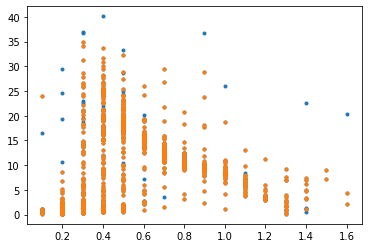

In [50]:
plt.plot(prae["Mass"],prae["Prot"],'.')
plt.plot(prae["Mass"][prae["QFClean"]==1],prae["Prot"][prae["QFClean"]==1],'.')

In [51]:
p_tau_sq = np.zeros(len(model_ages))
for i, age in enumerate(model_ages):
    p_tau_sq[i] = calc_tausq_praesepe(model_year,age,period_scale)

935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935
935


Text(0, 0.5, 'tau squared')

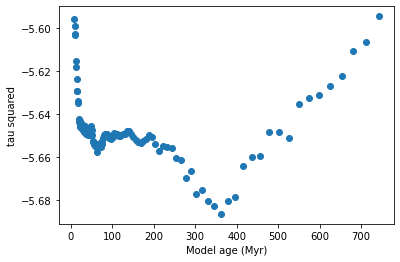

In [52]:
plt.plot(model_ages,p_tau_sq,'o')
plt.xlabel("Model age (Myr)")
plt.ylabel("tau squared")